In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from ase.build import bulk

# Build a bulk structure of MgO with rocksalt crystal structure
# Then, replace some of the Mg atoms with Fe atoms at a specified ratio.
conv_cell = bulk("MgO", crystalstructure="rocksalt", a=4.2, cubic=True)
rng = np.random.default_rng(123)
replace_element = "Mg"
new_elements=("Mg", "Fe")
supercell_size = 4
supercell_diag = (supercell_size, supercell_size, supercell_size)
T_low = 100
T_high = 1000
ratios = list(np.linspace(0.1, 0.9, 17, endpoint=True))
snapshot_counts = 50
window=(40, 40)
debug_mode = False
num_bins = 200

In [ ]:
from joblib import Parallel, delayed
from monty.serialization import loadfn
import tc.dataset
import tc.testing
from mace.calculators import mace_mp
import tc.wang_landau
from pymatgen.io.ase import AseAtomsAdaptor
import math
from monty.serialization import dumpfn

def _single_wl(ratio, seed):
    rng = np.random.default_rng(seed)
    sampler = tc.wang_landau.initialize_wl_sampler(
        ensemble, rng=rng, ratio=ratio, num_bins=num_bins, seeds=[seed], window=window)
    occ_enc = tc.wang_landau.initialize_supercell_occupancy(ensemble, rng, replace_element, new_elements, ratio)
    nsamples = int(10_000 * ensemble.num_sites)
    thin_by = max(1, math.ceil(nsamples / snapshot_counts))
    sampler.run(nsamples, occ_enc, thin_by=thin_by, progress=False)
    return sampler

# Only create the ensembles if they do not already exist
filename = f"{''.join(new_elements)}O_ensemble{supercell_size}.json.gz"
try:
    ensemble, endpoint_energies = loadfn(filename)
    print("Ensemble already exist, skipping creation.")
except FileNotFoundError:
    print(f"Creating random snapshot ensemble with {snapshot_counts} snapshots...")
    calc = mace_mp(model="large", device="cuda", default_dtype="float32")
    endpoint_energies = tc.dataset.calculate_endpoint_energies(conv_cell, calc, replace_element, new_elements)
    snapshots = tc.dataset.make_snapshots(conv_cell, supercell_diag, rng, replace_element, new_elements, snapshot_counts, ratios=ratios)
    ensemble = tc.dataset.create_canonical_ensemble(conv_cell, calc, replace_element, new_elements, supercell_size, endpoint_energies, supercell_diag, snapshots, reuse_site_map=True)
    if debug_mode:
        stats = tc.testing.evaluate_ensemble_vs_mace(ensemble=ensemble, calc=calc, conv_cell=conv_cell, rng=rng, endpoint_energies=endpoint_energies, replace_element=replace_element, new_elements=new_elements, comps=ratios)

    # Use Wang-Landau to sample configurations uniformly across the range of energies
    seed_root = np.random.SeedSequence(42) # master seed
    child_seeds = seed_root.spawn(len(ratios))
    n_workers = 6
    print(f"Using {n_workers} workers for parallel sampling.")
    samplers = Parallel(n_jobs=n_workers, backend="loky")(
        delayed(_single_wl)(r, s) for r, s in zip(ratios, child_seeds)
    )
        
    # Retrain the ensemble with the Wang-Landau configurations
    wl_occupancies = [occ for sampler in samplers for occ in sampler.samples.get_trace_value("occupancy")]
    snapshots = [AseAtomsAdaptor.get_atoms(ensemble.processor.structure_from_occupancy(occ)) for occ in wl_occupancies]
    ensemble = tc.dataset.create_canonical_ensemble(conv_cell, calc, replace_element, new_elements, supercell_size, endpoint_energies, supercell_diag, snapshots, reuse_site_map=True)
    dumpfn((ensemble, endpoint_energies), filename, indent=2)
    if debug_mode:
        stats = tc.testing.evaluate_ensemble_vs_mace(ensemble=ensemble, calc=calc, conv_cell=conv_cell, rng=rng, endpoint_energies=endpoint_energies, replace_element=replace_element, new_elements=new_elements, comps=ratios)
        # sampler = tc.wang_landau.run_wang_landau(ensemble, random_samples, rng, thin_target=snapshot_counts, ratio=ratio, n_samples_per_site=5_000, num_bins=200, window=(50,50), progress=True)
        # tc.testing.compare_sampler_and_mace(sampler, ensemble, calc, endpoint_eVpc=tuple(endpoint_energies), cation_elements=new_elements)

/home/colin/miniforge/envs/tc312/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  _Jd, _W3j_flat, _W3j_indices = torch.load(os.path.join(os.path.dirname(__file__), 'constants.pt'))


Ensemble already exist, skipping creation.


Sampling 10000 configurations with 179 Li and 77 Mn...


  0%|          | 0/10000 [00:00<?, ?it/s]

ratio: 0.7 CE energies: mean = -3067.46 meV, std =   474.94 meV, min = -4948.29 meV, max = -1287.75 meV
Energy window : [-22.065, 15.930] eV (200 bins, 0.1900 eV each)


Sampling 1 chain(s) from a cell with 512 sites: 100%|██████████| 1024000/1024000 [02:04<00:00, 8236.69it/s]
/mnt/z/disorder/tc/wang_landau.py:251: RuntimeWarning:

divide by zero encountered in divide

/mnt/z/disorder/tc/wang_landau.py:251: RuntimeWarning:

invalid value encountered in divide

/mnt/z/disorder/tc/wang_landau.py:252: RuntimeWarning:

divide by zero encountered in divide

/mnt/z/disorder/tc/wang_landau.py:252: RuntimeWarning:

invalid value encountered in divide

/mnt/z/disorder/tc/wang_landau.py:253: RuntimeWarning:

invalid value encountered in subtract

<string>:24: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



min(raw) = -15.795800032712627 eV
max(raw) = 10.990705189357424 eV
ΔE = 26.78650522207005 eV


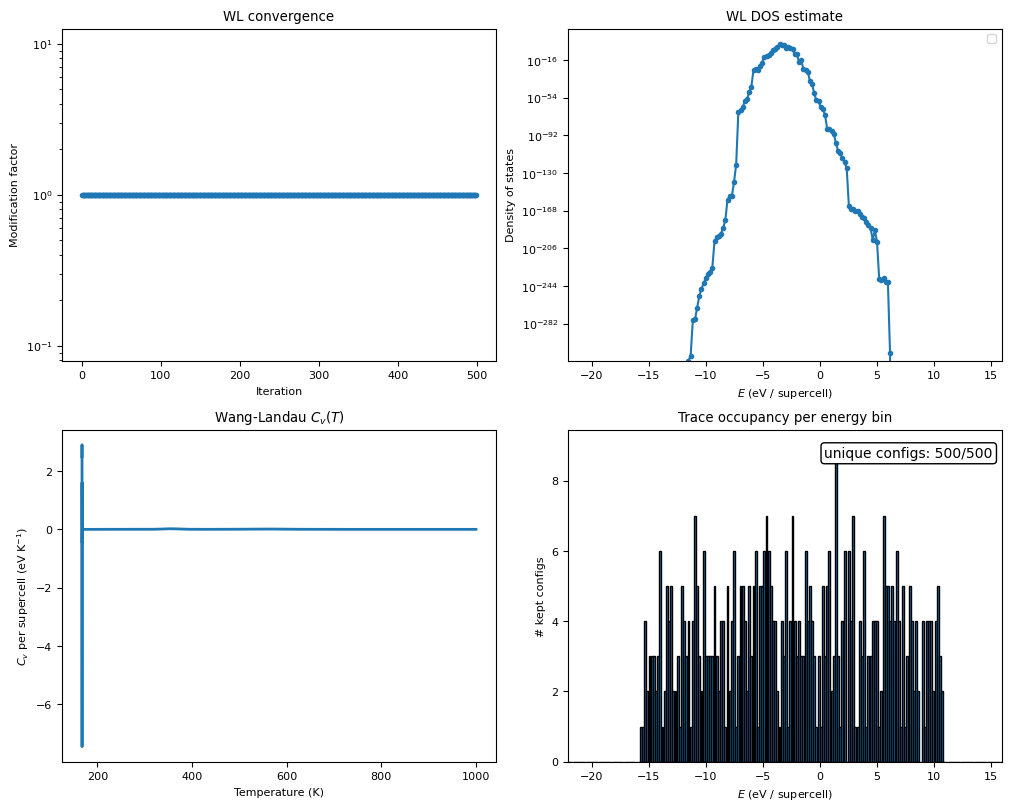

In [ ]:
import tc.wang_landau
import tc.testing

samples = tc.testing.sample_configs_fast(ensemble, rng, n_samples=10_000, ratio=0.7)
sampler = tc.wang_landau.run_wang_landau(ensemble=ensemble, samples=samples, rng=rng,
                                                                     ratio=0.7, n_samples_per_site=2_000, num_bins=200,
                                                                     window=window, progress=True)
temperatures_K = np.linspace(T_low, T_high, 1_000)
Cv = tc.wang_landau.compute_thermodynamics(sampler, temperatures_K)
tc.wang_landau.generate_wl_plots(sampler, temperatures_K, Cv)

Metropolis:   0%|          | 0/200 [00:00<?, ?T/s]

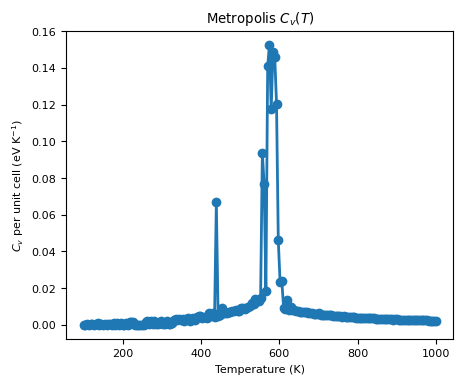

In [ ]:
"""
Parallel Metropolis heat-capacity sweep
"""

import os, numpy as np
from concurrent.futures import ProcessPoolExecutor
from tqdm.auto import tqdm
import tc.metropolis

# Temperatures to sample and an independent RNG seed for every worker (avoids accidental correlations).
Ts = np.linspace(T_low, T_high, 200)
seed_root = np.random.SeedSequence(42) # master seed
child_seeds = seed_root.spawn(len(Ts))

def _single_Cv(T, seed):
    rng = np.random.default_rng(seed)
    return tc.metropolis.run_metropolis_heat_capacity(
        ensemble, # cheap shallow copy is enough (I hope)
        T,
        rng,
        replace_element=replace_element,
        new_elements=new_elements,
        ratio=ratio,
        n_steps_per_site=10_000,
        thin_target=40_000,
    )

# Fan the temperature points out to all available cores.
n_workers = os.cpu_count() // 2 # type: ignore # leave some cores free for the GUI and other tasks for my laptop
print(f"Using {n_workers} workers for parallel sampling.")
with ProcessPoolExecutor(max_workers=n_workers) as pool:
    Cv = list(tqdm(pool.map(_single_Cv, Ts, child_seeds), total=len(Ts), desc="Metropolis", unit="T"))

tc.metropolis.plot_cv_curve(Ts, np.array(Cv))


In [ ]:
from joblib import Parallel, delayed
import numpy as np

import tc.wang_landau
import math

# ── input parameters ────────────────────────────────────────────────
seed_root = np.random.SeedSequence(42) # master seed
n_samples_per_site  = 50_000
mod_factor_threshold = 1e-6  # threshold for modification factor to consider a sampler converged
max_loops = 10  # maximum number of loops to run for each ratio
n_workers = 6

def _run_wl_to_convergence(ratio, sampler, seed):
    if sampler is None:
        rng = np.random.default_rng(seed)
        sampler = tc.wang_landau.initialize_wl_sampler(
            ensemble, rng=rng, ratio=ratio, num_bins=num_bins, seeds=[seed], window=window)
        occ_enc = tc.wang_landau.initialize_supercell_occupancy(ensemble, rng, replace_element, new_elements, ratio)
        mod_factor = sampler.bias.lnf
    else:
        occ_enc = None  # reuse the occupancy from the existing sampler
        mod_factor = sampler.samples.get_trace_value('mod_factor')[-1]
        if mod_factor <= mod_factor_threshold:
            print(f"[p={ratio:4.2f}] Sampler already converged with ln f = {mod_factor:8.2e}.")
            return sampler
    
    nsamples = int(n_samples_per_site * ensemble.num_sites)
    thin_by = max(1, math.ceil(nsamples / snapshot_counts))
    loop_count = 0
    while mod_factor > mod_factor_threshold and loop_count < max_loops:
        print(f"[p={ratio:4.2f}]  loop {loop_count}  ln f={mod_factor:8.2e}")
        sampler.run(nsamples, occ_enc, thin_by=thin_by, progress=False)
        mod_factor = sampler.samples.get_trace_value('mod_factor')[-1]
        occ_enc = None
        loop_count += 1

    status = "converged" if mod_factor <= mod_factor_threshold else "GAVE UP"
    print(f"[p={ratio:4.2f}] {status} after {loop_count} loop(s); ln f={mod_factor:8.2e}")
    return sampler

child_seeds = [int(x) for x in seed_root.generate_state(len(ratios)).tolist()]
print(f"Using {n_workers} workers for parallel sampling.")
samplers = Parallel(n_jobs=n_workers, backend="loky")(
    delayed(_run_wl_to_convergence)(ratio, sampler, seed) for ratio, sampler, seed in zip(ratios, samplers, child_seeds)
)


Using 6 workers for parallel sampling.
[p=0.10] Sampler already converged with ln f = 4.77e-07.
[p=0.15]  loop 0  ln f=7.63e-06
[p=0.20]  loop 0  ln f=6.10e-05
[p=0.25]  loop 0  ln f=3.91e-03
[p=0.30]  loop 0  ln f=4.88e-04
[p=0.35]  loop 0  ln f=3.05e-05
[p=0.40]  loop 0  ln f=3.91e-03


In [22]:
import tc.wang_landau

temperatures = np.linspace(200, 1500, 10000)
Cv_mat = np.empty((len(ratios), len(temperatures)))
for i, sampler in enumerate(samplers):
    Cv_mat[i, :] = tc.wang_landau.compute_thermodynamics(sampler, temperatures)
fig = tc.wang_landau.plot_cv_surface(ratios, temperatures, Cv_mat, mode="scatter", engine="plotly")
fig.show()

In [24]:
dos_mat = tc.wang_landau.compute_dos_matrix(samplers)
for ratio, sample in zip(ratios, samplers):
    print(f"[ratio {ratio:.3f}]  final mod-factor = {sample.samples.get_trace_value('mod_factor')[-1]:.3e}")
fig = tc.wang_landau.plot_dos_surface(ratios, dos_mat, mode="scatter", engine="plotly")
fig.show()

[ratio 0.100]  final mod-factor = 4.768e-07
[ratio 0.150]  final mod-factor = 7.629e-06
[ratio 0.200]  final mod-factor = 2.441e-04
[ratio 0.250]  final mod-factor = 3.906e-03
[ratio 0.300]  final mod-factor = 1.953e-03
[ratio 0.350]  final mod-factor = 3.052e-05
[ratio 0.400]  final mod-factor = 3.906e-03
[ratio 0.450]  final mod-factor = 4.883e-04
[ratio 0.500]  final mod-factor = 1.907e-06
[ratio 0.550]  final mod-factor = 1.907e-06
[ratio 0.600]  final mod-factor = 9.537e-07
[ratio 0.650]  final mod-factor = 1.907e-06
[ratio 0.700]  final mod-factor = 1.907e-06
[ratio 0.750]  final mod-factor = 2.384e-07
[ratio 0.800]  final mod-factor = 2.980e-08
[ratio 0.850]  final mod-factor = 7.276e-12
[ratio 0.900]  final mod-factor = 4.768e-07


In [7]:

hist_mat  = tc.wang_landau.compute_histogram_matrix(samplers)   # prints final mod-factors
fig = tc.wang_landau.plot_hist_heatmap(ratios, hist_mat, engine="plotly")
fig.show()